In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [2]:
# Load CIFAR-10 dataset
(train_images, _), (_, _) = cifar10.load_data()
train_images = (train_images.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1,1]
train_images = train_images.reshape(-1, 32, 32, 3)  # CIFAR-10 images are (32, 32, 3)

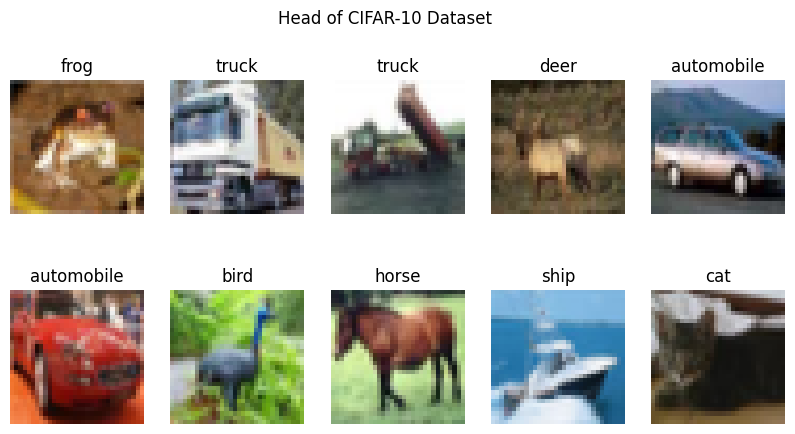

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(train_images, train_labels), (_, _) = cifar10.load_data()

# CIFAR-10 Class Names
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Display the first few images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])  # Use class_names to label images
    plt.axis("off")

plt.suptitle("Head of CIFAR-10 Dataset")
plt.show()


In [30]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32
EPOCHS = 100
NOISE_DIM = 100

In [31]:
# Create batches of training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [32]:
# Function to create the Generator
def build_generator():
    model = Sequential([
        Dense(8 * 8 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((8, 8, 256)),
        
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [33]:
# Function to create the Discriminator
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(32, 32, 3)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [34]:

# Create Generator and Discriminator
generator = build_generator()
discriminator = build_discriminator()

# Define Loss Function and Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)


In [35]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_6 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 128)       524288    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 128)      

In [36]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [37]:
# Function to compute the loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [38]:
# Define Training Step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [39]:
import matplotlib.pyplot as plt

def generate_and_save_images(epoch):
    noise = tf.random.normal([16, NOISE_DIM])
    generated_images = generator(noise, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        img = (generated_images[i] + 1) / 2  # Normalize from [-1,1] to [0,1]
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle(f"Generated Images at Epoch {epoch}")
    
    plt.show()  #Ensures the image is displayed in Jupyter Notebook

    # Also save the images for reference
    plt.savefig(f"generated_images_epoch_{epoch}.png")


Training Started...
Epoch 1/100 - Generator Loss: 6.4837, Discriminator Loss: 0.0016 - Time Taken: 486.90 sec


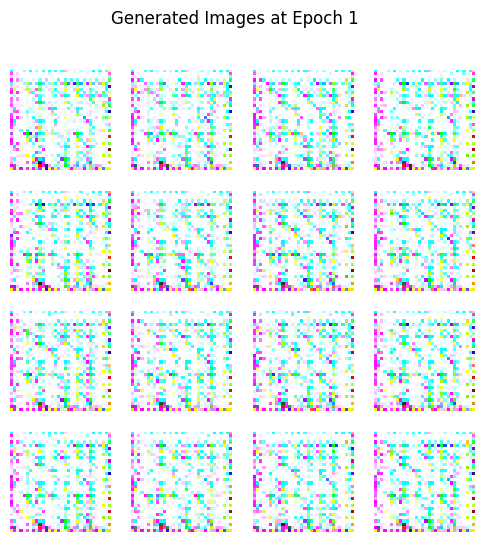

Epoch 2/100 - Generator Loss: 9.7165, Discriminator Loss: 0.0001 - Time Taken: 496.61 sec


<Figure size 640x480 with 0 Axes>

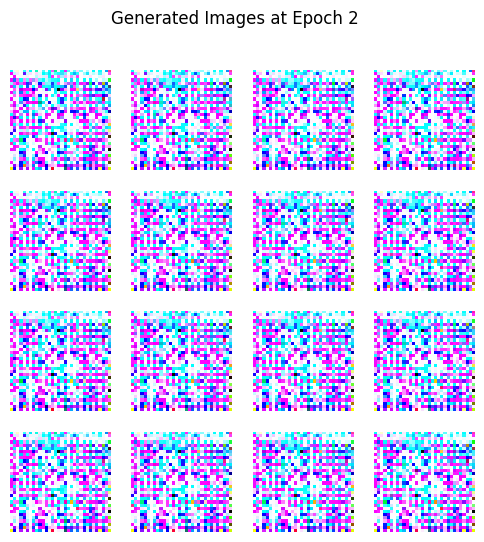

Epoch 3/100 - Generator Loss: 10.4181, Discriminator Loss: 0.0000 - Time Taken: 480.79 sec


<Figure size 640x480 with 0 Axes>

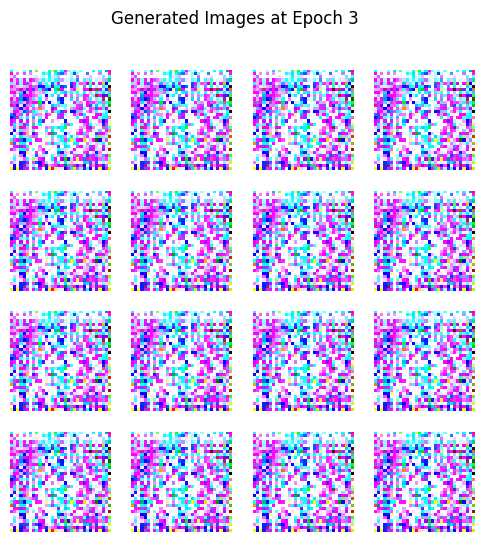

Epoch 4/100 - Generator Loss: 12.4764, Discriminator Loss: 0.0000 - Time Taken: 469.39 sec


<Figure size 640x480 with 0 Axes>

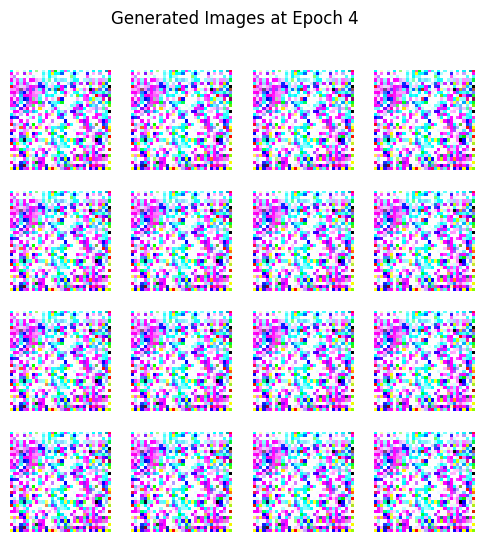

Epoch 5/100 - Generator Loss: 5.7920, Discriminator Loss: 0.0032 - Time Taken: 425.84 sec


<Figure size 640x480 with 0 Axes>

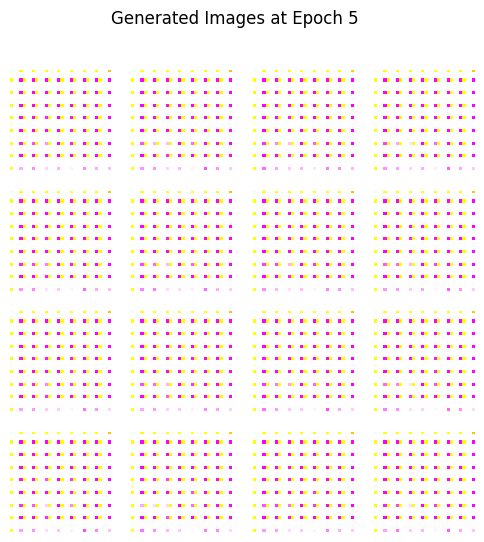

Epoch 6/100 - Generator Loss: 10.4533, Discriminator Loss: 0.0000 - Time Taken: 427.32 sec


<Figure size 640x480 with 0 Axes>

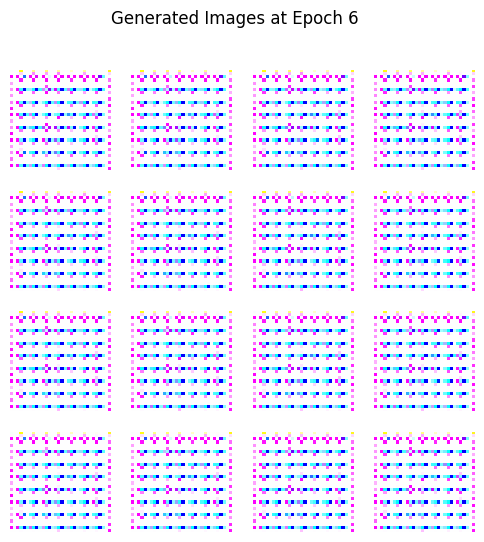

Epoch 7/100 - Generator Loss: 11.5354, Discriminator Loss: 0.0000 - Time Taken: 424.20 sec


<Figure size 640x480 with 0 Axes>

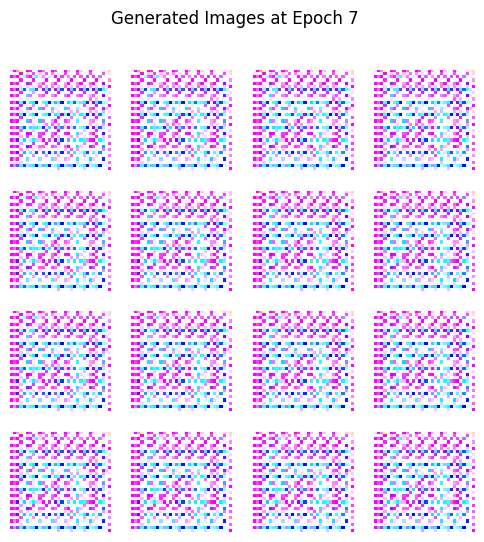

Epoch 8/100 - Generator Loss: 12.7645, Discriminator Loss: 0.0000 - Time Taken: 428.94 sec


<Figure size 640x480 with 0 Axes>

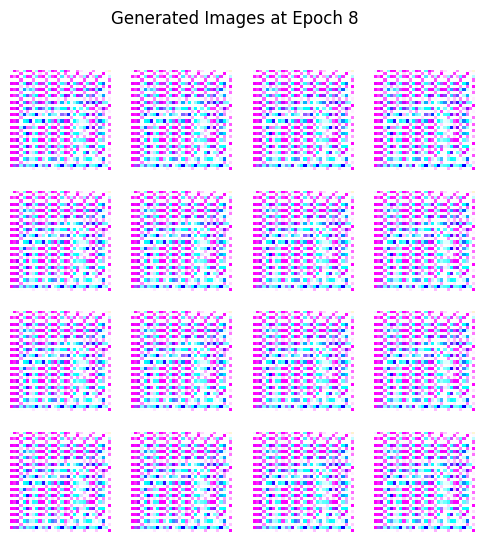

Epoch 9/100 - Generator Loss: 14.0540, Discriminator Loss: 0.0000 - Time Taken: 422.70 sec


<Figure size 640x480 with 0 Axes>

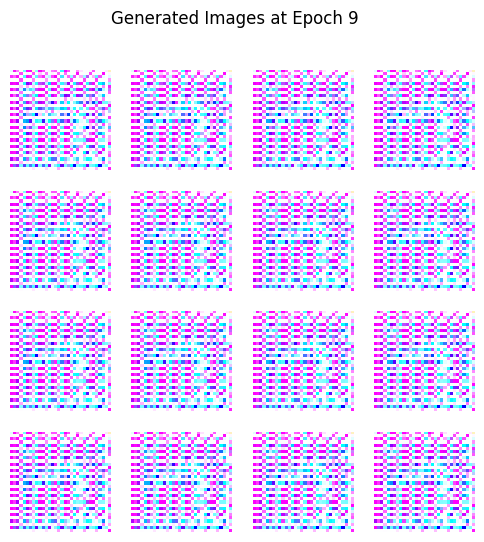

Epoch 10/100 - Generator Loss: 13.1187, Discriminator Loss: 0.0000 - Time Taken: 569.11 sec


<Figure size 640x480 with 0 Axes>

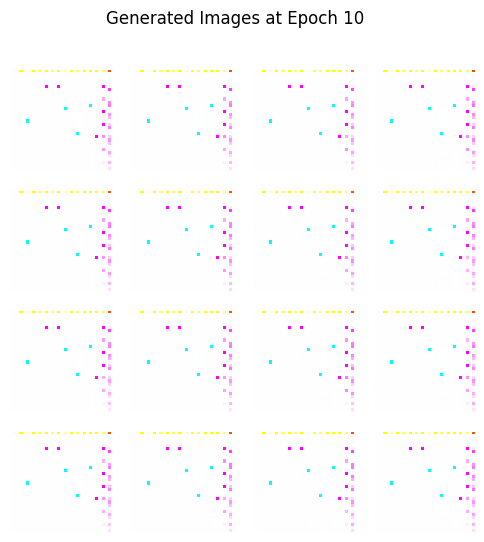

Epoch 11/100 - Generator Loss: 13.5633, Discriminator Loss: 0.0000 - Time Taken: 663.29 sec


<Figure size 640x480 with 0 Axes>

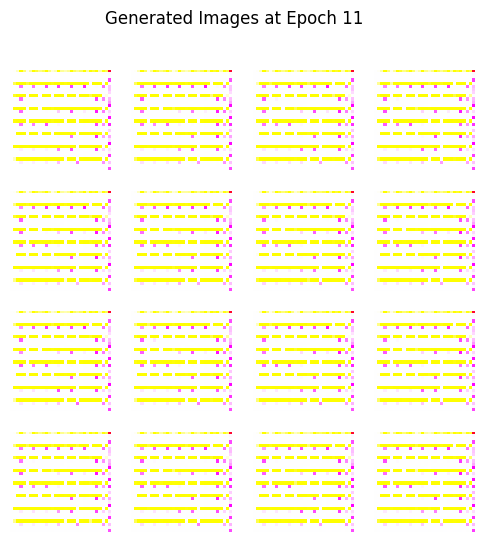

Epoch 12/100 - Generator Loss: 15.9415, Discriminator Loss: 0.0000 - Time Taken: 797.99 sec


<Figure size 640x480 with 0 Axes>

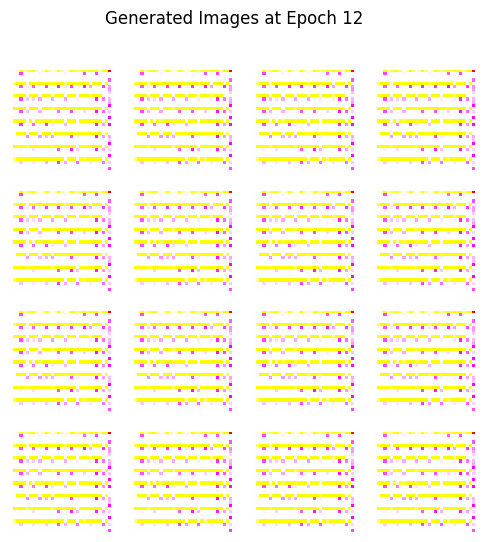

Epoch 13/100 - Generator Loss: 16.4574, Discriminator Loss: 0.0000 - Time Taken: 772.61 sec


<Figure size 640x480 with 0 Axes>

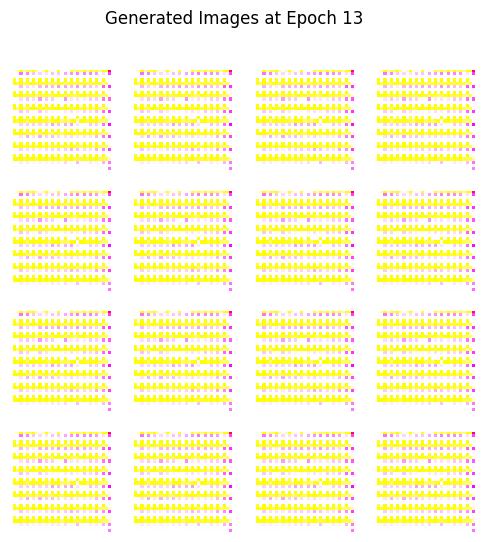

Epoch 14/100 - Generator Loss: 17.8254, Discriminator Loss: 0.0000 - Time Taken: 786.92 sec


<Figure size 640x480 with 0 Axes>

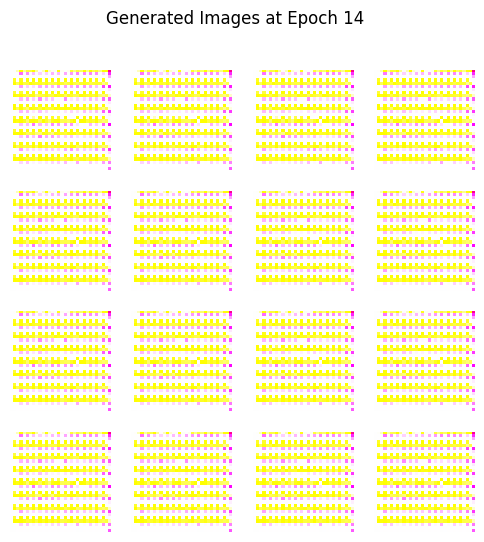

Epoch 15/100 - Generator Loss: 18.6945, Discriminator Loss: 0.0000 - Time Taken: 804.81 sec


<Figure size 640x480 with 0 Axes>

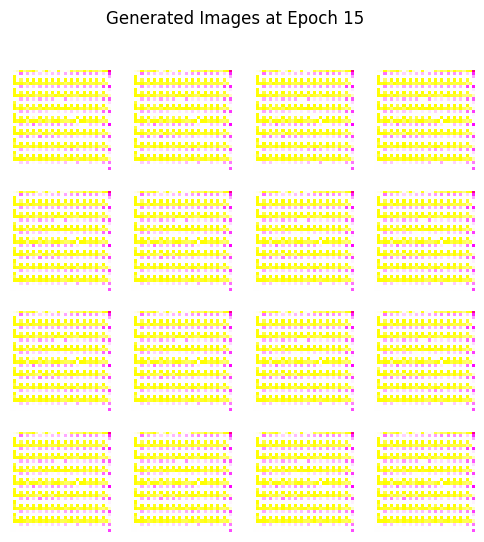

Epoch 16/100 - Generator Loss: 18.5760, Discriminator Loss: 0.0000 - Time Taken: 424.73 sec


<Figure size 640x480 with 0 Axes>

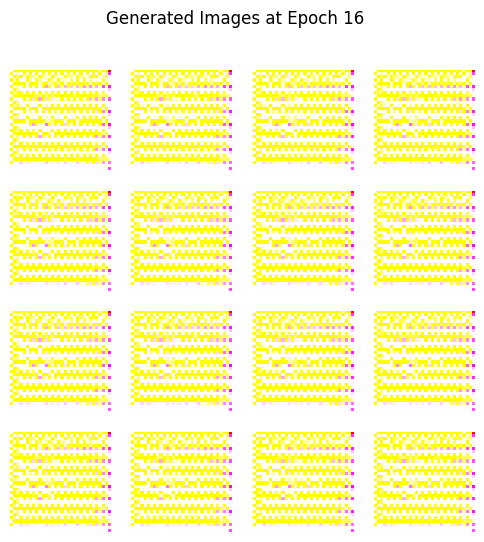

Epoch 17/100 - Generator Loss: 19.0618, Discriminator Loss: 0.0000 - Time Taken: 422.88 sec


<Figure size 640x480 with 0 Axes>

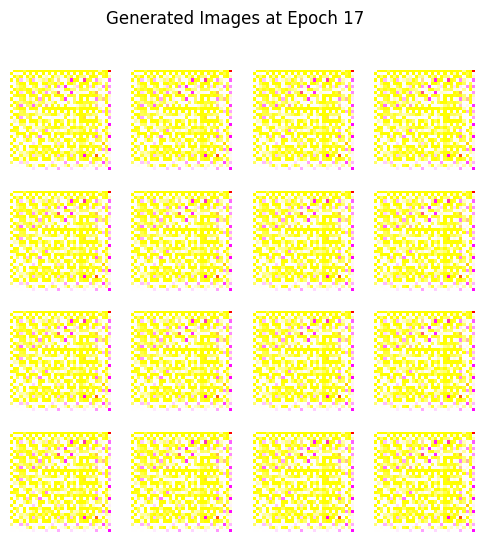

Epoch 18/100 - Generator Loss: 20.7067, Discriminator Loss: 0.0000 - Time Taken: 425.02 sec


<Figure size 640x480 with 0 Axes>

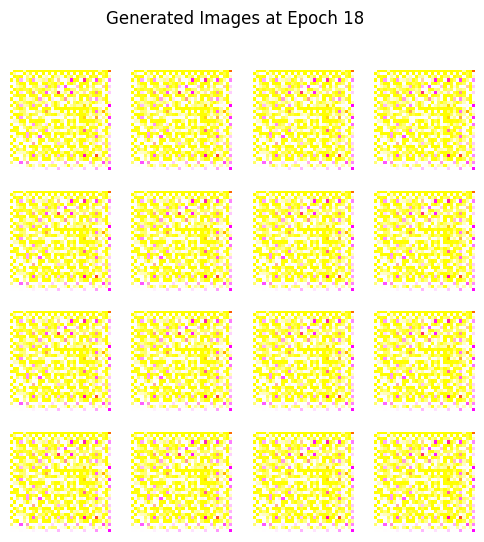

Epoch 19/100 - Generator Loss: 21.8088, Discriminator Loss: 0.0000 - Time Taken: 507.89 sec


<Figure size 640x480 with 0 Axes>

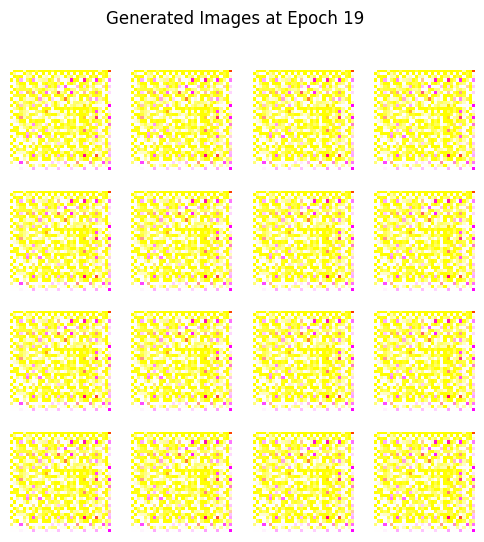

Epoch 20/100 - Generator Loss: 22.5794, Discriminator Loss: 0.0000 - Time Taken: 518.18 sec


<Figure size 640x480 with 0 Axes>

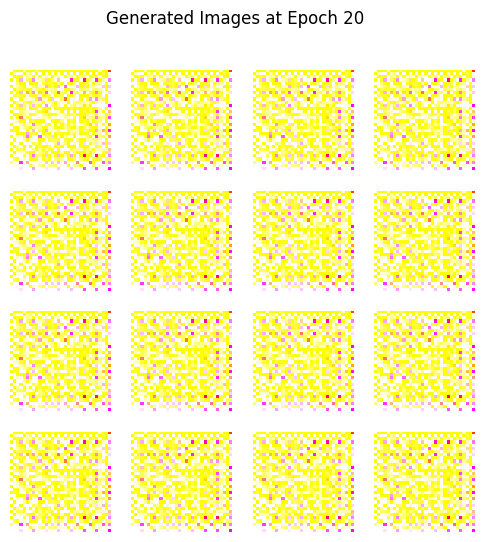

Epoch 21/100 - Generator Loss: 23.5285, Discriminator Loss: 0.0000 - Time Taken: 522.01 sec


<Figure size 640x480 with 0 Axes>

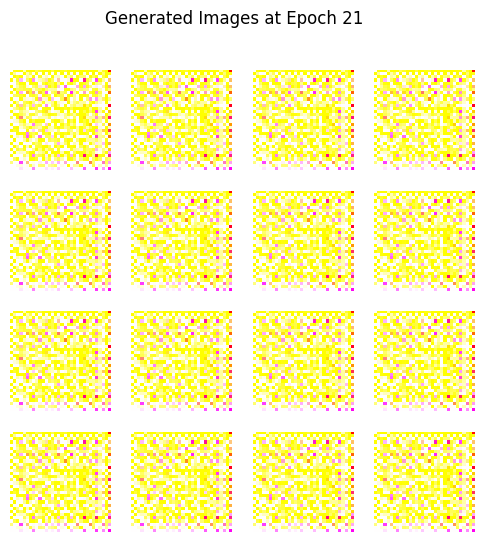

Epoch 22/100 - Generator Loss: 12.7695, Discriminator Loss: 0.0000 - Time Taken: 523.76 sec


<Figure size 640x480 with 0 Axes>

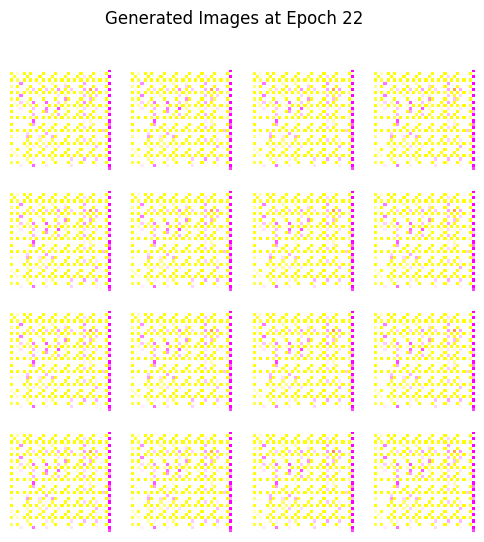

Epoch 23/100 - Generator Loss: 12.9668, Discriminator Loss: 0.0000 - Time Taken: 530.06 sec


<Figure size 640x480 with 0 Axes>

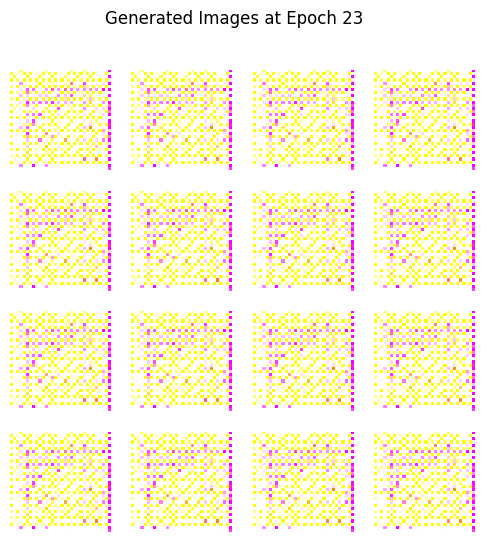

Epoch 24/100 - Generator Loss: 13.7573, Discriminator Loss: 0.0000 - Time Taken: 525.77 sec


<Figure size 640x480 with 0 Axes>

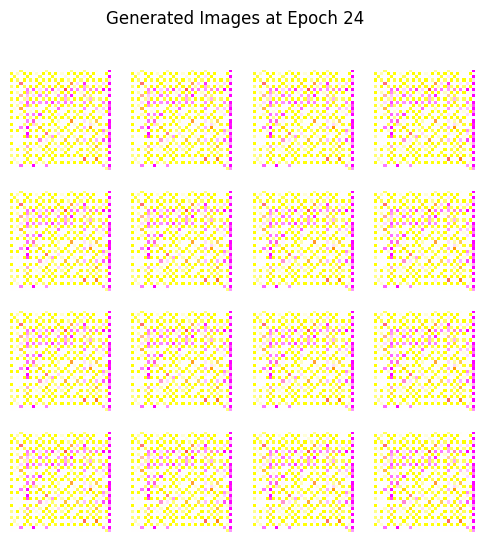

Epoch 25/100 - Generator Loss: 14.5220, Discriminator Loss: 0.0000 - Time Taken: 537.96 sec


<Figure size 640x480 with 0 Axes>

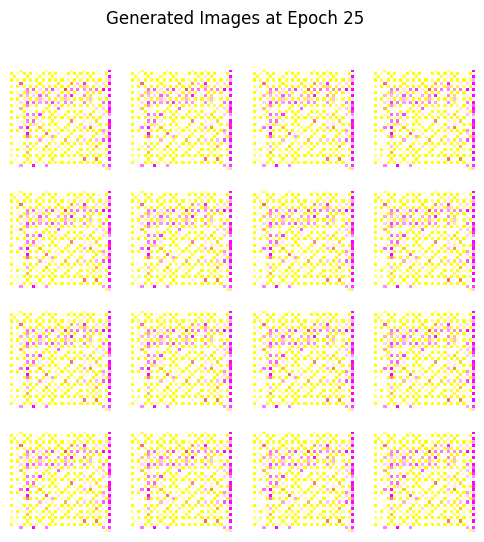

Epoch 26/100 - Generator Loss: 15.2400, Discriminator Loss: 0.0000 - Time Taken: 532.56 sec


<Figure size 640x480 with 0 Axes>

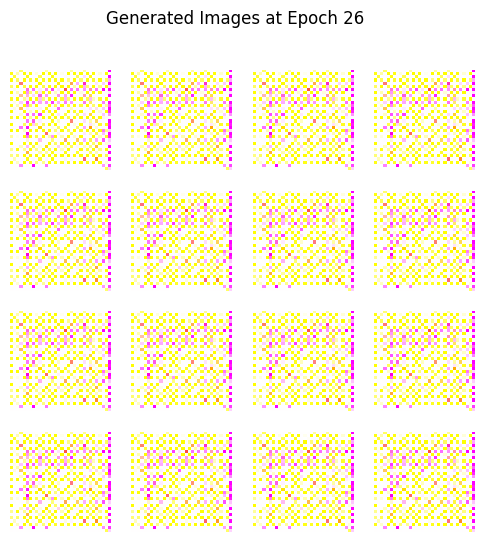

Epoch 27/100 - Generator Loss: 16.1393, Discriminator Loss: 0.0000 - Time Taken: 521.95 sec


<Figure size 640x480 with 0 Axes>

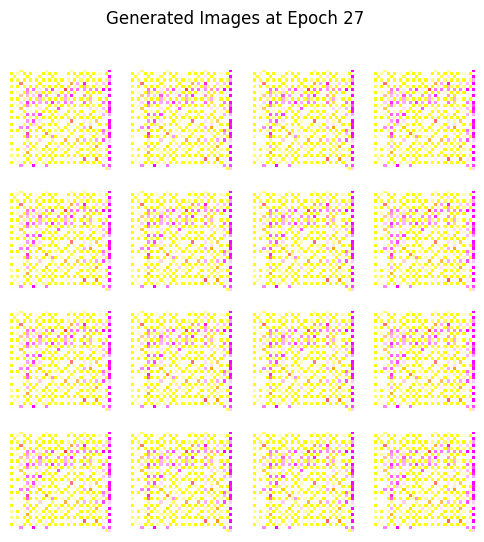

Epoch 28/100 - Generator Loss: 16.7943, Discriminator Loss: 0.0000 - Time Taken: 525.84 sec


<Figure size 640x480 with 0 Axes>

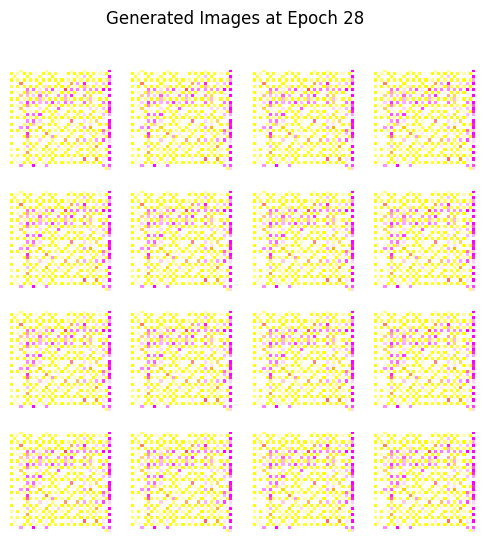

Epoch 29/100 - Generator Loss: 17.5896, Discriminator Loss: 0.0000 - Time Taken: 518.20 sec


<Figure size 640x480 with 0 Axes>

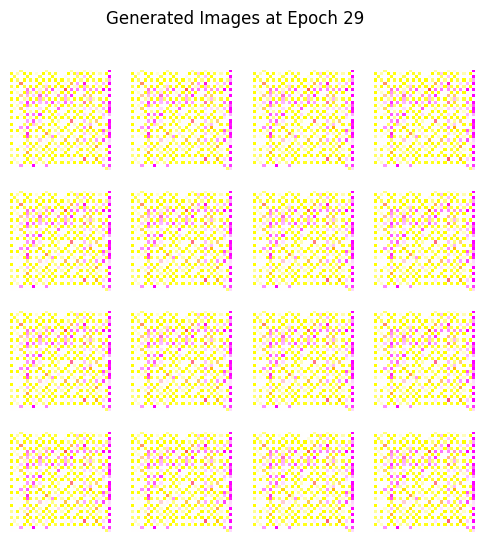

Epoch 30/100 - Generator Loss: 18.4116, Discriminator Loss: 0.0000 - Time Taken: 522.24 sec


<Figure size 640x480 with 0 Axes>

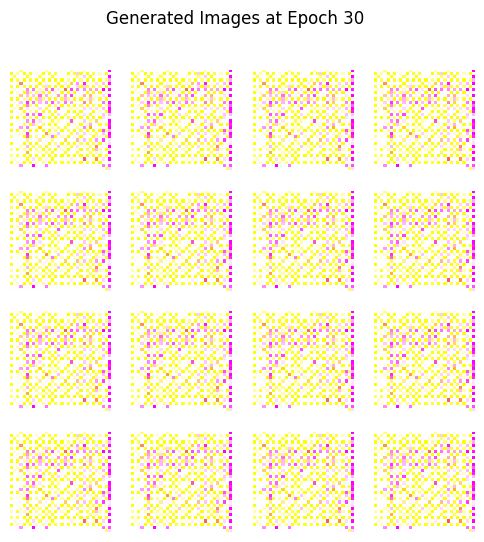

Epoch 31/100 - Generator Loss: 18.9239, Discriminator Loss: 0.0000 - Time Taken: 524.12 sec


<Figure size 640x480 with 0 Axes>

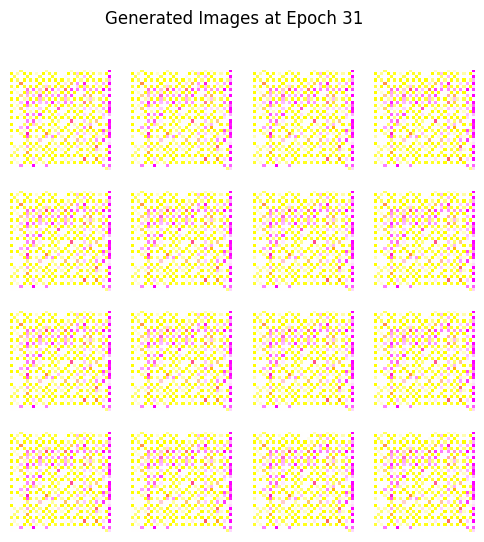

Epoch 32/100 - Generator Loss: 20.1129, Discriminator Loss: 0.0000 - Time Taken: 526.70 sec


<Figure size 640x480 with 0 Axes>

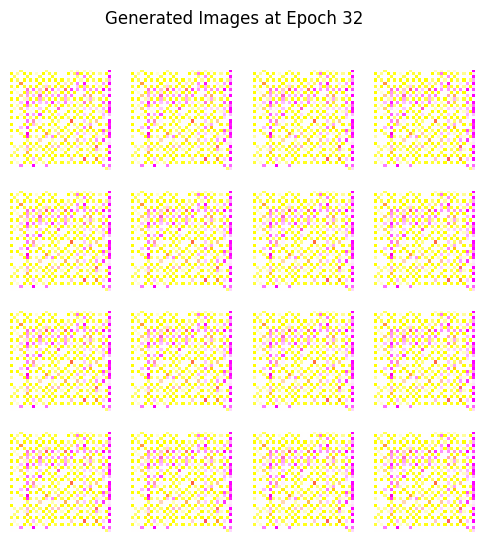

Epoch 33/100 - Generator Loss: 20.6479, Discriminator Loss: 0.0000 - Time Taken: 521.10 sec


<Figure size 640x480 with 0 Axes>

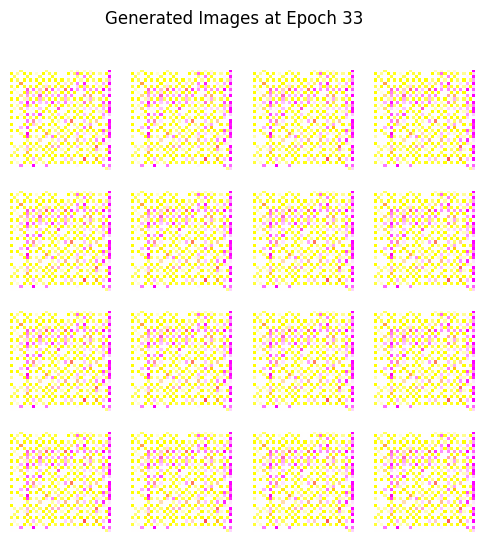

Epoch 34/100 - Generator Loss: 21.7008, Discriminator Loss: 0.0000 - Time Taken: 475.77 sec


<Figure size 640x480 with 0 Axes>

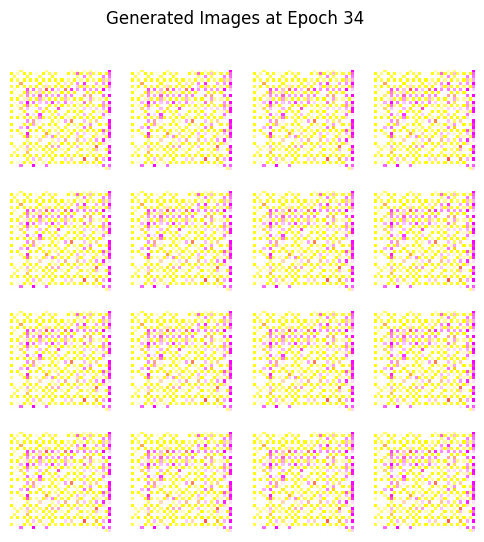

Epoch 35/100 - Generator Loss: 22.3378, Discriminator Loss: 0.0000 - Time Taken: 426.33 sec


<Figure size 640x480 with 0 Axes>

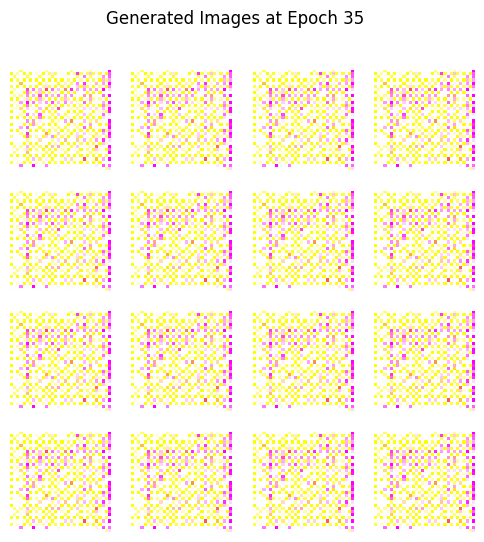

Epoch 36/100 - Generator Loss: 23.2756, Discriminator Loss: 0.0000 - Time Taken: 427.76 sec


<Figure size 640x480 with 0 Axes>

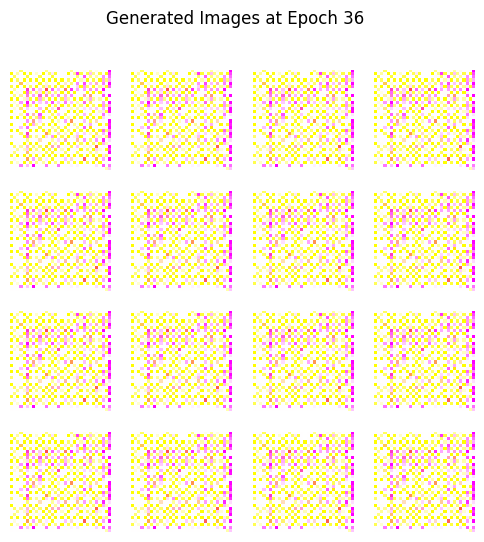

Epoch 37/100 - Generator Loss: 24.1972, Discriminator Loss: 0.0000 - Time Taken: 612.58 sec


<Figure size 640x480 with 0 Axes>

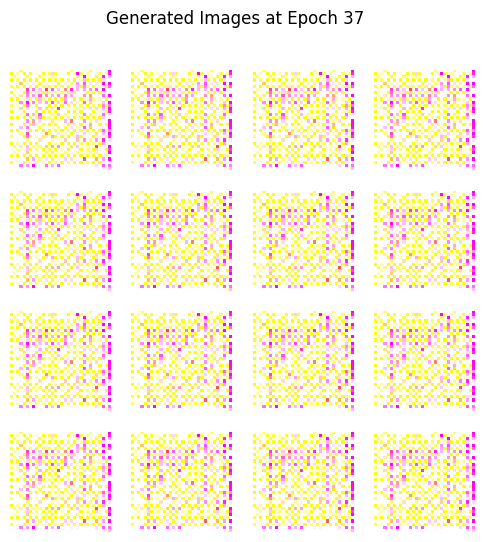

Epoch 38/100 - Generator Loss: 24.5272, Discriminator Loss: 0.0000 - Time Taken: 796.83 sec


<Figure size 640x480 with 0 Axes>

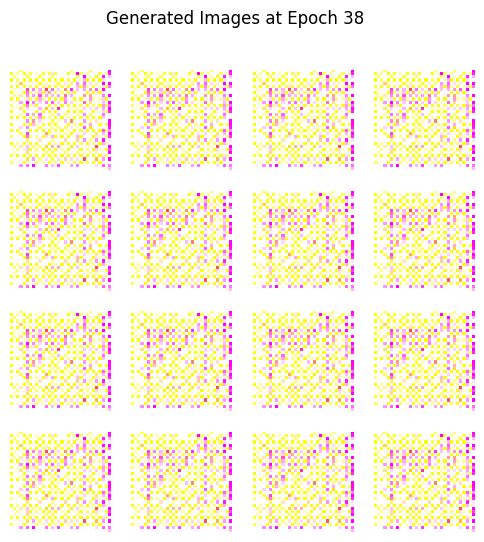

Epoch 39/100 - Generator Loss: 25.2650, Discriminator Loss: 0.0000 - Time Taken: 764.91 sec


<Figure size 640x480 with 0 Axes>

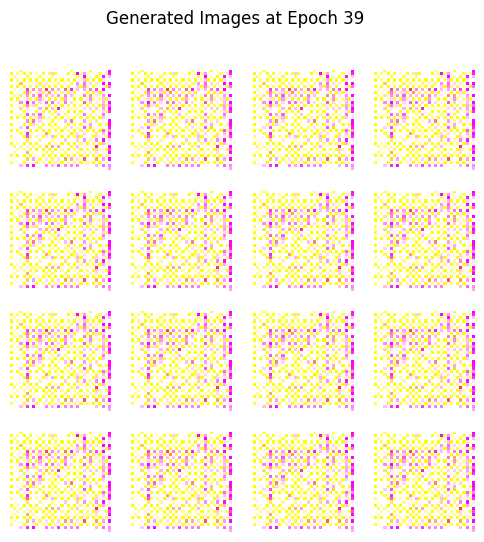

Epoch 40/100 - Generator Loss: 26.0308, Discriminator Loss: 0.0000 - Time Taken: 799.79 sec


<Figure size 640x480 with 0 Axes>

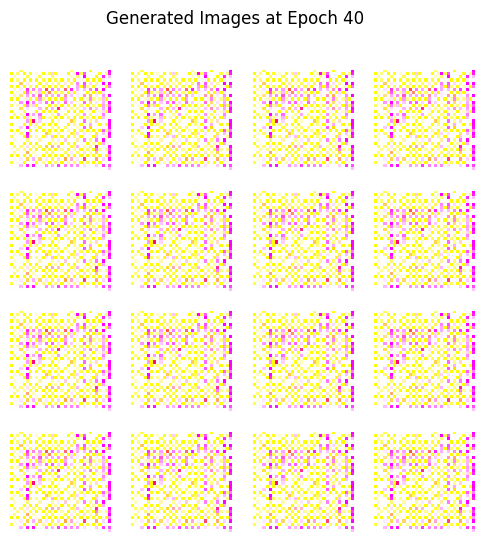

Epoch 41/100 - Generator Loss: 26.3384, Discriminator Loss: 0.0000 - Time Taken: 864.92 sec


<Figure size 640x480 with 0 Axes>

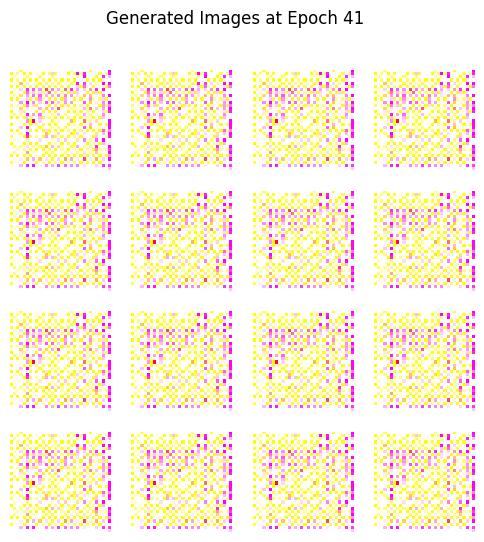

Epoch 42/100 - Generator Loss: 26.7598, Discriminator Loss: 0.0000 - Time Taken: 847.09 sec


<Figure size 640x480 with 0 Axes>

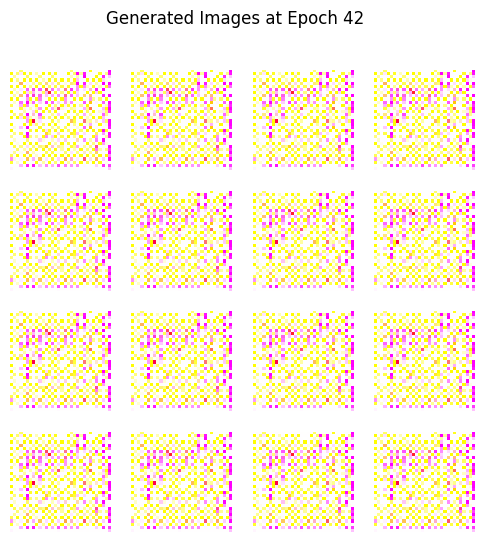

Epoch 43/100 - Generator Loss: 26.7271, Discriminator Loss: 0.0000 - Time Taken: 630.02 sec


<Figure size 640x480 with 0 Axes>

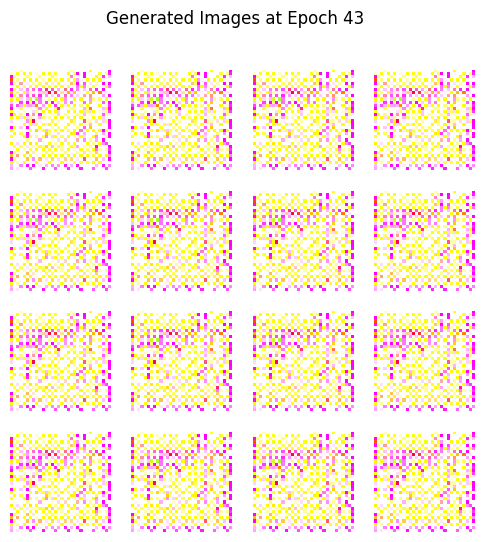

Epoch 44/100 - Generator Loss: 6.0828, Discriminator Loss: 0.0031 - Time Taken: 542.12 sec


<Figure size 640x480 with 0 Axes>

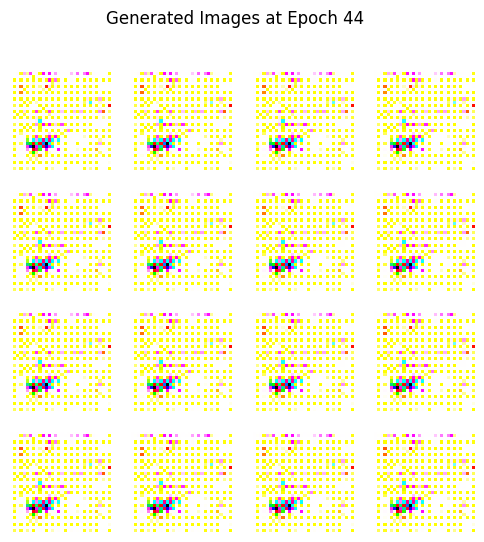

Epoch 45/100 - Generator Loss: 9.7149, Discriminator Loss: 0.0001 - Time Taken: 509.34 sec


<Figure size 640x480 with 0 Axes>

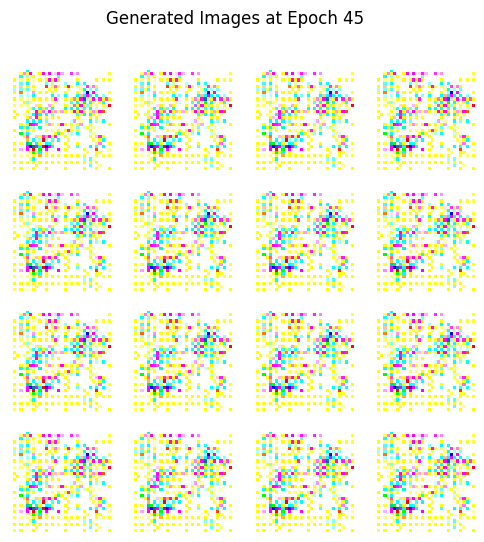

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Nakul Limbani\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Nakul Limbani\AppData\Local\Temp\ipykernel_18388\2960818477.py", line 24, in <module>
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\tensorflow\python\eager\backprop.py", line 1066, in gradient
    flat_grad = imperative_grad.imperative_grad(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\tensorflow\python\eager\imperative_grad.py", line 67, in imperative_grad
    return pywrap_tfe.TFE_Py_TapeGradient(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\tensorflow\python\eager\backprop.py", lin

<Figure size 640x480 with 0 Axes>

In [40]:
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

print("Training Started...")

for epoch in range(EPOCHS):
    start_time = time.time()

    for image_batch in train_dataset:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                        cross_entropy(tf.zeros_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    end_time = time.time()
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f} - Time Taken: {end_time - start_time:.2f} sec")

    # Ensure images are displayed after every epoch
    generate_and_save_images(epoch + 1)

# Save Models After Training
generator.save("cifar10_generator.h5")
discriminator.save("cifar10_discriminator.h5")
print("Training Complete and Models Saved!")


In [42]:
# Plot the loss curves at the end
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), gen_losses, label="Generator Loss", marker='o')
plt.plot(range(1, EPOCHS + 1), disc_losses, label="Discriminator Loss", marker='x')
plt.title("Generator and Discriminator Loss Over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

KeyboardInterrupt: 

In [ ]:
# Function to compute FID score
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(32, 32, 3))
    
    real_images = preprocess_input((real_images + 1) * 127.5)  # Rescale back to [0,255]
    generated_images = preprocess_input((generated_images + 1) * 127.5)
    
    real_features = model.predict(real_images)
    generated_features = model.predict(generated_images)
    
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
    
    fid_score = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))
    return fid_score


In [ ]:
# Generate images for FID Calculation
num_images = 1000
real_images = train_images[:num_images]
noise = tf.random.normal([num_images, NOISE_DIM])
generated_images = generator(noise, training=False)

# Compute FID Score
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score}")

In [3]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32
EPOCHS = 100  # ⬆️ More epochs for better training
NOISE_DIM = 100

# Optimize Data Pipeline with Prefetching
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

print("Dataset Loaded Successfully!")

NameError: name 'tf' is not defined

In [43]:
# ✅ More powerful Generator
def build_generator():
    model = Sequential([
        Dense(8 * 8 * 512, use_bias=False, input_shape=(NOISE_DIM,)),
        BatchNormalization(),
        LeakyReLU(),

        Reshape((8, 8, 512)),  # More filters

        Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, kernel_size=4, strides=1, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()
print("Generator Model Defined")


Generator Model Defined


In [44]:
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32768)             3276800   
                                                                 
 batch_normalization_13 (Ba  (None, 32768)             131072    
 tchNormalization)                                               
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_13 (Conv2  (None, 16, 16, 256)       2097152   
 DTranspose)                                                     
                                                                 
 batch_normalization_14 (Ba  (None, 16, 16, 256)      

In [45]:
# Discriminator now weaker (to balance training)
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(32, 32, 3)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Flatten(),
        Dense(1, activation='sigmoid')  # ✅ Sigmoid ensures probability output
    ])
    return model

discriminator = build_discriminator()
print("Discriminator Model Defined")


Discriminator Model Defined


In [2]:
discriminator.summary()

NameError: name 'discriminator' is not defined